# REINFORCE

В данном задании мы решим одну из самых простых задач представленных в gym 'CartPole-v0' с помощью метода policy gradient.

In [1]:
%env THEANO_FLAGS='floatX=float32'
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

env: THEANO_FLAGS='floatX=float32'
Starting virtual X frame buffer: Xvfb../xvfb: line 8: start-stop-daemon: command not found
.
env: DISPLAY=:1


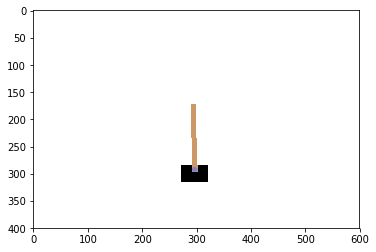

In [2]:
import gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0").env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

# Построим агента для  REINFORCE

Для алгоритма REINFORCE нам понадобится модель, которая предсказывает вероятности действий в заданных состояниях. Давайте определим такую модель ниже.

In [3]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [ ]:
#Построить простую нейронную сеть, которая предсказывает logits политики. 
#CartPole решается простой сетью.
agent = nn.Sequential(
    <Ваш код здесь.>
)


#### Predict function

In [8]:
def predict_proba(states):
    """ 
    Predict action probabilities given states.
    :param states: numpy array of shape [batch, state_shape]
    :returns: numpy array of shape [batch, n_actions]
    """
    # конвертируйте states, посчитайте logits, используйте softmax для получения вероятностного распределения
    <ваш код здесь>
    return < и здесь >

In [9]:
test_states = np.array([env.reset() for _ in range(5)])
test_probas = predict_proba(test_states)
assert isinstance(test_probas, np.ndarray), "верните nparray, а не %s" % type(test_probas)
assert tuple(test_probas.shape) == (test_states.shape[0], n_actions), "ошибочные размеры выхода: %s" % np.shape(test_probas)
assert np.allclose(np.sum(test_probas, axis = 1), 1), "вероятность не суммируется в 1"

### Play the game

We can now use our newly built agent to play the game.

In [10]:
def generate_session(t_max=1000):
    """ 
    play a full session with REINFORCE agent and train at the session end.
    returns sequences of states, actions andrewards
    """
    
    #заведем массивы для наших состояний, действий и наград
    states,actions,rewards = [],[],[]
    
    s = env.reset()
    
    for t in range(t_max):
        
        #распределение действий в текущем состоянии pi(a|s)
        action_probas = predict_proba(np.array([s]))[0] 

        a = <семплируйте действие по распределению выше>
        
        new_s,r,done,info = env.step(a)
        
        #созраняем состояния
        states.append(s)
        actions.append(a)
        rewards.append(r)
        
        s = new_s
        if done: break
            
    return states, actions, rewards

In [11]:
# Проверим это
states, actions, rewards = generate_session()

### Расчет кумулятивной награды

Имплементируйте функцию ниже:
вам дается список награды за целую сессию
посчитайте кумулятивную награду G(s,a) с понижением ее стоимости на каждом шаге.

$G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...$

Наиболее простой способ это сделать - итерироваться от последнего состояния к первому  и считать рекуррентно  $G_t = r_t + gamma*G_{t+1}$


In [ ]:
def get_cumulative_rewards(rewards, #награды на каждом шаге
                           gamma = 0.99 #discount для награды (коэффициент уменьшения ценности награды)
                           ):
    """
    Computation of cumulative rewards G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ..
    :return: array of cummulative rewards
    """
    <Вы должны вернуть массив / список накопительных вознаграждений с таким количеством элементов, как в первоначальных вознаграждениях.>
    <Ваш код здесь>   
    return <array of cumulative rewards>

In [13]:
get_cumulative_rewards(rewards)
assert len(get_cumulative_rewards(list(range(100)))) == 100
assert np.allclose(get_cumulative_rewards([0,0,1,0,0,1,0],gamma=0.9),[1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(get_cumulative_rewards([0,0,1,-2,3,-4,0],gamma=0.5), [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(get_cumulative_rewards([0,0,1,2,3,4,0],gamma=0), [0, 0, 1, 2, 3, 4, 0])
print("Успех!")

looks good!


#### Loss function and updates

We now need to define objective and update over policy gradient.

Давайте теперь определим нашу целевую функцию и обновления с помощью policy gradient метода.

Целевая функция:

$$ J \approx  { 1 \over N } \sum  _{s_i,a_i} \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$


Следуя алгоритму REINFORCE, можно определить ее так

$$ \hat J \approx { 1 \over N } \sum  _{s_i,a_i} log \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$

Когда мы считаем градиент от нашей функции по параметрам $ \theta $, то это становится в точности policy gradient.


Известная уже нам функция.

In [ ]:
def to_one_hot(y, n_dims=None):
    """ Take an integer vector (tensor of variable) and convert it to 1-hot matrix. """
    y_tensor = y.detach() if y.requires_grad else y
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
    
    return y_one_hot.requires_grad_() if y.requires_grad else y_one_hot

In [ ]:
# Определим оптимизатор
# Вы знаете что делать


def train_on_session(states, actions, rewards, gamma = 0.99):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """
    
    # Приводим все к тензорам с градиентами
    states = torch.tensor(states, requires_grad=True, dtype=torch.float)
    actions = torch.tensor(actions, requires_grad=True, dtype=torch.int)
    cumulative_returns = np.array(get_cumulative_rewards(rewards, gamma))
    cumulative_returns = torch.tensor(cumulative_returns, requires_grad=True, dtype=torch.float)
    
    # предсказывам logits, probas and log-probas используюя нашего агента. 
    logits = <your code here>
    probas = <your code here>
    logprobas = <your code here>
    
    assert all(v.requires_grad for v in [logits, probas, logprobas]), \
        "не забывайте про градиенты у тензоров"
    
    # выбираем log-probabilities для каждого действия, log pi(a_i|s_i)
    logprobas_for_actions = torch.sum(logprobas * to_one_hot(actions), dim = 1)
    
    # целевая функция для REINFORCE
    J_hat = <policy objective as in the formula for J_hat. Please use mean, not sum.>
    
    #регуляризатор энтропией ( не обязательно ) 
    entropy_reg = <compute mean entropy of probas. Don't forget the sign!>
    
    loss = - J_hat - 0.1 * entropy_reg
    
    <Gradient descent step>
    
    # Возвращаем награды, чтобы потом из было удобно отрисовать
    return np.sum(rewards)

### Тренировка агента

In [ ]:
for i in range(100):
    #генерируем новые сессии
    rewards = [train_on_session(*generate_session()) for _ in range(100)] 
    
    print ("mean reward:%.3f"%(np.mean(rewards)))

    if np.mean(rewards) > 300:
        print ("Победа!") 
        break

### Видео

In [16]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),directory="videos",force=True)
sessions = [generate_session() for _ in range(100)]
env.close()


In [17]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices